## Tutorial on Autoencoders using Tensorflow and MNIST Dataset

This tutorial is an introduction on autoencoders in deep learning. We will implement an autoencoder with [TensorFlow](https://www.tensorflow.org/) and [MNIST](https://www.tensorflow.org/versions/r1.2/get_started/mnist/beginners) dataset.

## What is an Autoencoder?

An autoecoder is a type of feed foward neural network that learns its input as the target output. The number of units in hidden layers of the autoencoder is less than the input dimension, forcing the network to learn a compressed representation of input, the ___encoding___,  and reconstruct the origianl input from the _encoding_. To put it in short, an autoencoder is trying to learn a hypothesis $h$, where $h(x) = x$. Because _encoding_ is less representative than the original input, the autoencoder will perceive the important features of the input and remove the noise. But the downside of it is that the output will inevitably lose some information regarding the input. Comparing autoencoders to other dimension reduction algorithms like [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (Principal component analysis), the output space of autoencoders can be more complicated because of the non-linearity of the deep network.


Although autoencoders can learn compressed representation of input, they are not as general as the normal compression algorithm like compression a zip file. In other words, outputs of autoencoders highly depend on the input data that they are trained on. An autoencoder trained on image dataset will not work for audio input.



## Why Autoencoders

Up to this point, you may understand that an autoencoder can learn the essential features of the input with a compressed representation, and reconstruct the original input. But how are autoencoders used in practical applications? Here are some points why autoencoders are interesting.


1. Dimension Reduction
> The _encoding_ encodes the important features of the original input, which can be used in dimension reduction. Compared to other dimension reduction techniques like [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) and [LDA](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) (Linear discriminant analysis), autoencoders introduce the non-linearity by selecting different network architectures and activation functions.
2. Data Denoising
> As mentioned above, autoencoders can learn important features and remove the noise in raw data. That being said, autoencoders are able learn compact representations robust to noise. ___Denoising autoencoders___ take input with noise and reconstruct the origianl input. At the end of this tutorial, we will add some noise to our testing dataset to see if our autoencoder is robust to noise.
3. Detecting Adversarial Samples in Deep Learning
> Deep neural networks are known to be vulnerable to adversarial examples. Adversarial examples are the samples that look like one class for human, but are classified to the other class by machine. There are some defenses that make the model more robust to adversarial examples, and one of them is [MagNet](https://arxiv.org/abs/1705.09064), that has a detector in front of the classifier to either reject those who looks like adversarial examples, and reform those who look benign to be more far away from adversary. The detector is implemented using autoencoder. We will not go into details here, but you can refer to the paper by the link for more information.

## Architecture of Autoencoders

Autoencoder include the ___encoder___ and the ___decoder___. The encoder maps the input to lower dimension representation, the ___encoding___. The decoder reconstruct the target output from the _encoding_. Let $X$ be the input, $Z$ be the encoding, and $X'$ be the output. An autoencoder consists of the following equations:


$encoder(X) = Z$

$decoder(Z) = X'$

such that $||X - X'||_2$ is minimized.

As aboved mentioned, autoencoders use the input as the target output/label. The target of the training process is to minimize the difference between the output and the original input. Here we use [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) as our distance function. An example figure of an autoencoder is as below:

<img src="https://www.learnopencv.com/wp-content/uploads/2017/11/AutoEncoder.png">


In this case, the architecture is a very simple feed forward, fully connected neural network with 1 hidden layer. The input dimension is 5, and the output dimension should be the same as the input dimension. The encoding dimension is 3, which is a lower dimension projection of input. Later we will implement an autoencoder which has a similar look of the architecture, but with more hidden layers and more hidden units. In practice, autoencoders can apply to more types of deep neural nets such as [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network) (Convolutional neural network).

## Installing the libraries

We will be using TensorFlow and NumPy for implementation. You can install the libraries using native `pip`, `pip3`. Before this, make sure you have `pip3` version 8.1 or higher in order to install TensorFlow.

To check your pip version:

    $ pip3 -V # for Python 3.n 
    
To upgrade your pip:

    $ sudo easy_install --upgrade pip
$ sudo easy_install --upgrade six 
    
Then you can install TensorFlow:

    $ pip3 install tensorflow     # Python 3.n; CPU support

To install NumPy:
     
    $ pip3 install numPy
    
Note that we are using `pip3` here because we are using the python3 kernel. For more information about the installation, you can consult [here](https://www.tensorflow.org/install/install_mac) for TensorFlow and [here](https://scipy.org/install.html) for NumPy. After you install the libraries, run the following commands to see if your installation succeeds:



In [1]:
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import numpy as np

## Dataset

We will use the MNIST dataset to build our autoencoder. MNIST is a simple dataset of handwritten digits from 0 to 9, and is often used in machine learning algorithms. Here is how it looks like:

<img src="http://tensorlayer.readthedocs.io/en/latest/_images/mnist.jpeg"  >

TensorFlow already has some useful functions for MNIST. We can load our data using the following command:

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Note that the arguement `one_hot=True`. One hot is a way of encoding that all the values are zero except for the real label that the sample corresponds to should be 1. For example, if there are 2 samples and the label vector is `[1,3]`, and 4 classes (0, 1, 2, 3). The one hot encoding looks like this:

    [[0, 1, 0, 0], [0, 0, 0, 1]]


Next we split our dataset into training, validation, and testing dataset. As mentioned in the lecture, training dataset is used to train the parameters in the network, validation dataset is used for finding good hyperparameters, and testing dataset, only used once,  is used for evaluating the network.

The MNIST dataset is split into 55000 training samples (`mnist.train.images`), 5000 validation samples (`mnist.validation.images`), and 10000 testing samples (`mnist.test.images`). Each sample is image of size 28 x 28 with 1 color channel. Here we flatten each sample into a 784 dimension vector.

In [4]:
mnist.train.images.shape, mnist.validation.images.shape, mnist.test.images.shape

((55000, 784), (5000, 784), (10000, 784))

In [5]:
# Split into train, test, and validation dataset
X_train = mnist.train.images
X_test = mnist.test.images
X_valid = mnist.validation.images

# Although TensorFlow provides the labels, we won't be using this in our tutorial
Y_train = mnist.train.labels
Y_test = mnist.test.labels
Y_valid = mnist.validation.labels


## Define the autoencoder architecture

The architecture of a neural network often refers to the type of layers (fully connected, convolution...etc), number of hidden layers, the number of units in each layer, and the activation functions. Before going deep into the network architecture, let's first take a look at a single neuron.

A neuron is like a sinlge perceptron: $y = \sigma(WX + b)$ where $X$ is the input, $W$ is the parameters, $b$ is the bias, and $y$ is the output. Here $\sigma$ is the activation function. In our case, we are using $sigmoid$ as the activation function, a differentiable function that bounds the output between 0 and 1. There are other activation functions like $tanh$ and $relu$ that have different effect on the deep neural net. You can take a look at more activation functions [here](https://www.tensorflow.org/api_guides/python/nn). 


TensorFlow provides a module [layers](https://www.tensorflow.org/api_docs/python/tf/layers) that makes our life easier. This module contains of multiple types of high level neural network layers. Here we are using the _dense_ layer, which is the fully connected layer that we mentioned above. The syntex is straightforward by specifying the inputs of this layer, the number of units, and the activation function. Here we specify `use_bias=True` to compute $WX + b$ (b is the bias vector).


### Specifying Our Autoencoder
Our autoencoder has the architecture that looks like this: 

- original input (784 dimensions) 
- hidden layer (324 dimensions) 
- encoding (121 dimensions) 
- hidden layer (324 dimensions) 
- output (784 dimensions)

Here we split the autoencoder into `encoder` and `decoder`. `encoder` encodes the inputs to `encoding`, and `decoder` takes `encoding` as the input to reconstruct inputs.


In [6]:
def encoder(x):
    encode_h1 = tf.layers.dense(inputs=x, units=324, activation=tf.sigmoid, use_bias=True)
    encoding = tf.layers.dense(inputs=encode_h1, units=121, activation=tf.sigmoid, use_bias=True) 
    
    return encode_h1, encoding

def decoder(encoding):
    decode_h1 = tf.layers.dense(inputs=encoding, units=324, activation=tf.sigmoid, use_bias=True) 
    x_decode = tf.layers.dense(inputs=decode_h1, units=784, activation=tf.sigmoid, use_bias=True) 
    
    return decode_h1, x_decode

### Define parameters

The next step after we have our autoencoder, we need to define some hyperparameters, loss function, and optimizer for training. You can find the best hyperparameters using validation set.

Note that up to this point, we are not running the training process yet, we are just defining our TensorFlow ___graph___. When using TensorFlow, we need to first define the graph, then run the graph using `tf.Session`, we will talk about this in the next section. Here `X` and `Y` are TensorFlow placeholders, which we will use it for the `feed_dict` in `tf.Session`.


### Loss Function and Optimizer 
In this example, we use the RMSProp optimizer, while in lectures we are more familiar with gradient descent. But the logic should be the same, that the optimizer is stepping forward to a minimal point on the error surface defined by our loss function. You can find more optimizers [here](https://www.tensorflow.org/api_guides/python/train). We define our loss function as the square of L2 distance $||X - X'||_2$, since taking a square root will make the optimizer go in the same direction, but take more time to compute the value.

In [7]:
# define some useful variables
input_dim = X_train.shape[1]
output_dim = 10  # digits 0 - 9
num_train = X_train.shape[0]
num_valid = X_valid.shape[0]
num_test = X_test.shape[0]



# hyper parameters
learning_rate = 0.01
batch_size = 64
num_epoch = 41


X = tf.placeholder(tf.float32, [None, input_dim])
Y = tf.placeholder(tf.int64, [None, output_dim])

Xe1, X_encode = encoder(X)          # X_encode is the encoding
Xd1, X_decode = decoder(X_encode)   # X_decode is the reconstructed output

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)

mean_loss = tf.reduce_mean(tf.pow(X - X_decode, 2))

# This is the operation that we will run during training
train_step = optimizer.minimize(mean_loss)


## Training

In TensorFlow, the operations need to be run using `tf.Session`. Before running our training operation, run the `tf.global_variables_initializer` to initialize the variables in the TensorFlow graph. 

We are running the training and validation in _batch_. That is, in every epoch, we don't feed the whole set of data into the graph directly. Instead, we feed a batch of data, whose size is defined by `batch_size`. The different between using batch and using the entire set of data is that the model calculates the loss and updates the parameters in every batch iteration. This makes our computation faster. The `train_loss_list` and `valid_loss_list` is used for plotting the loss versus epochs.

In [9]:
train_loss_list = []
valid_loss_list = []

epochs = [i for i in range(num_epoch)]
num_batch_train = math.ceil(num_train/batch_size)
num_batch_valid = math.ceil(num_valid/batch_size)
step = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for e in range(num_epoch):
    train_loss = 0

    for i in range(num_batch_train):          

        feed_dict = {X: X_train[i*batch_size: (i+1)*batch_size]}

        real_batch_size = X_train[i*batch_size: (i+1)*batch_size].shape[0]
        
        # run train_step and mean_loss operation, input is specified by feed_dict
        _, loss = sess.run([train_step, mean_loss], feed_dict=feed_dict)
            
        train_loss += loss * real_batch_size
    
    # calculate the training loss for the whole training set
    train_loss /= num_train
    
    # only print out the message and run on validation set for certain steps
    if e % step == 0 :
        valid_loss = 0
        for i in range(num_batch_valid):
            
            feed_dict_v = {X: X_valid[i*batch_size: (i+1)*batch_size]}
            
            real_batch_size_v = X_valid[i*batch_size: (i+1)*batch_size].shape[0]

            valid_loss += sess.run(mean_loss, feed_dict=feed_dict_v) * real_batch_size_v
        
        valid_loss /= num_valid
            
        print('Epoch %i: Train loss: %f, Validation loss: %f' % (e, train_loss, valid_loss))
        
        valid_loss_list.append((e, valid_loss))
 

    train_loss_list.append((e, train_loss)) 
    
    


Epoch 0: Train loss: 0.066793, Validation loss: 0.030650
Epoch 10: Train loss: 0.008240, Validation loss: 0.010048
Epoch 20: Train loss: 0.006626, Validation loss: 0.007924
Epoch 30: Train loss: 0.005901, Validation loss: 0.007632
Epoch 40: Train loss: 0.005445, Validation loss: 0.007028


## Plot loss

Visualize the training and validation loss with respect to epochs. Both of the loss converge at later epochs.

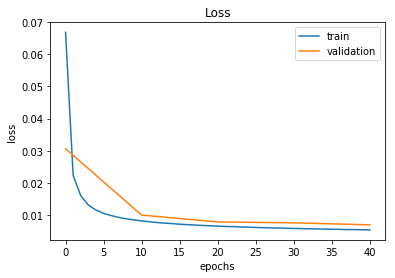

In [10]:
# plot train & validation loss

plt.plot(*zip(*train_loss_list), label="train")
plt.plot(*zip(*valid_loss_list), label="validation")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss")
plt.show()

## Evaluating the Autoencoder

Now evaluate our autoencoder using the test set. Note that the test set should only be run once. `X_reconstruct` is the reconstructed image, and `X_encoding` is the encoding.

In [11]:
X_reconstruct, X_encoding, xe1, xd1 = sess.run([X_decode, X_encode, Xe1, Xd1], feed_dict={X: X_test})

## Visualize the Output

Now that we have reconstructed the input image, let's plot it against the original input image to see the difference using [matplotlib](https://matplotlib.org/users/pyplot_tutorial.html). Here we are onlt plotting the first 33 images of the test set. The reconstructed images are highly recognizable, and they look very similar to the original input images. There are some regions where the reconstructed images are blurry. This is because the output is constrained by _encoding_, the bottleneck in the network.

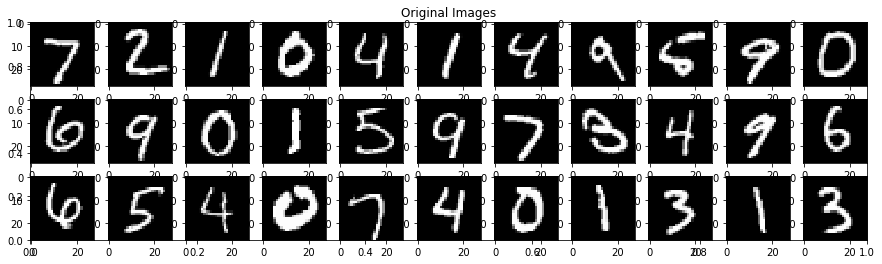

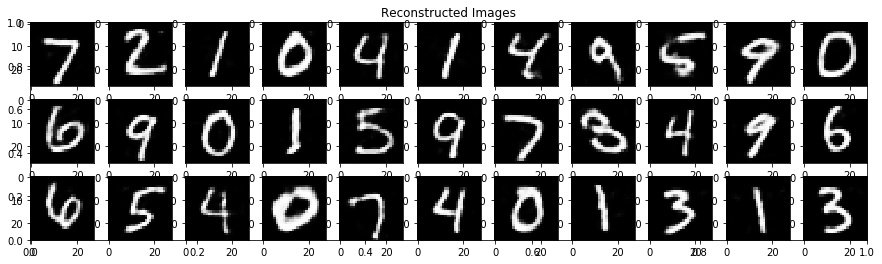

In [15]:
# Only show the first 33 images in the test set
w = 15
h = 4
cols = 11
rows = 3

# Plot the original images
fig = plt.figure(figsize=(w, h))
plt.title("Original Images")
for i in range(0, cols*rows):
    img = X_test[i].reshape((28,28))
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img,  cmap="gray")
plt.show()



fig = plt.figure(figsize=(w, h))
plt.title("Reconstructed Images")

for i in range(0, cols*rows):
    img = X_reconstruct[i].reshape((28,28))
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img,  cmap="gray")
plt.show()




We can also plot the encoding. In our case the encoding doesn't look much meaningful.

Encodings


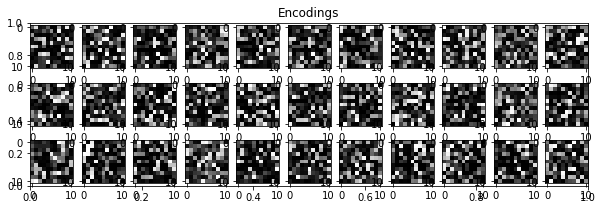

In [16]:
w = 10
h = 3
cols = 11
rows = 3

fig = plt.figure(figsize=(w, h))
plt.title("Encodings")

for i in range(0, cols*rows):
    img = X_encoding[i].reshape((11,11))
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img,  cmap="gray")
plt.show()



## Is Our Autoencoder Robust to Noise?

Although we did not train our autoencoder as a _denoising autoencoder_, we can still try with noisy inputs. Here we add some noise with random normal distribution onto test set.

In [17]:
noise_factor = 0.3

X_test_noisy = X_test.reshape((-1,28,28))+ noise_factor * np.random.normal(loc=0.0, scale=1.0, size=(28,28))

# X_test_noisy is X_test with noise
X_test_noisy = X_test_noisy.reshape((-1,784))



As we can see from the plot of noisy images and the reconstructed images, the autoencoder performs well on denoising. There are some small regions where the output has some noise, like `7` and `4` here, but overall the model seems robust to noise.

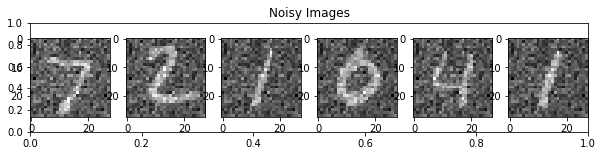

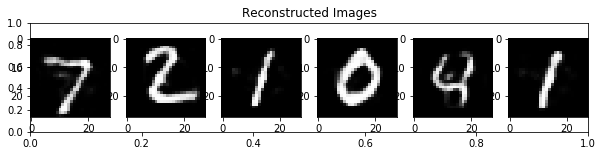

In [24]:
X_recon_niosy, _ = sess.run([X_decode, X_encode], feed_dict={X: X_test_noisy})

w = 10
h = 2
cols = 6
rows = 1

fig = plt.figure(figsize=(w, h))
plt.title("Noisy Images")

for i in range(0, cols*rows):
    img = X_test_noisy[i].reshape((28,28))
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img,  cmap="gray")
plt.show()


fig = plt.figure(figsize=(w, h))
plt.title("Reconstructed Images")

for i in range(0, cols*rows):
    img = X_recon_niosy[i].reshape((28,28))
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img,  cmap="gray")
plt.show()


## Close Session

At the end, don't forget to close the session.

In [25]:
sess.close()

## Summary and Reference

This tutorial gives an introduction on autoencoders and implementation with TensorFlow and other libraries. Below are some reference links and additional resources:

Autoencoder:
https://en.wikipedia.org/wiki/Autoencoder
<br>
MNIST dataset:
https://www.tensorflow.org/versions/r1.2/get_started/mnist/beginners
<br>
PCA:
https://en.wikipedia.org/wiki/Principal_component_analysis
<br>
LDA:
https://en.wikipedia.org/wiki/Linear_discriminant_analysis
<br>
CNN:
https://en.wikipedia.org/wiki/Convolutional_neural_network
<br>
Euclidean distance:
https://en.wikipedia.org/wiki/Euclidean_distance
<br>
TensorFlow Installation:
https://www.tensorflow.org/install/install_mac
<br>
matplotlib:
https://matplotlib.org/users/pyplot_tutorial.html
<br>
Image of autoencoder:
https://www.learnopencv.com/wp-content/uploads/2017/11/AutoEncoder.png
<br>
Image of MNIST:
http://tensorlayer.readthedocs.io/en/latest/user/tutorial.html
